In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy import linalg as la
from scipy import sparse

from trips.io import build_x_true
from trips.operators import gaussian_blur_operator, first_derivative_operator
from trips.solvers.gks import MMGKSClass

### construct a true image

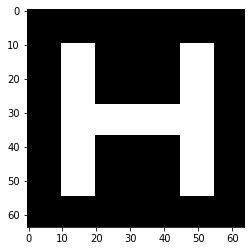

In [2]:
x_true = build_x_true().reshape(-1,1)

plt.imshow(x_true.reshape(64,64), cmap='Greys_r')

### apply an operator

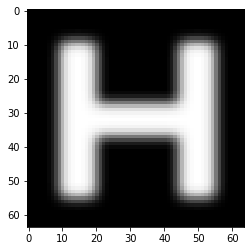

In [3]:
blur_operator = gaussian_blur_operator([9,9],2,64,64)

b_true = blur_operator @ x_true

plt.imshow( b_true.reshape(64,64), cmap='Greys_r')

### contaminate with noise

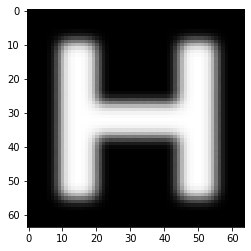

In [4]:
noise_level = 0.001
noise = np.random.randn(64*64)
e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
e = e.reshape(-1,1)
b = b_true + e
plt.imshow( b.reshape(64,64), cmap='Greys_r')

### construct regularization operators

In [5]:
I = pylops.Identity(4096) # identity operator
D = first_derivative_operator(n=4096) # first derivative operator
D2 = D @ D # second derivative operator

### run MMGKS with GCV

In [6]:
solver = MMGKSClass(pnorm=2, qnorm=1, projection_dim=3, regparam='gcv', dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running MMGKS...: 100%|██████████| 80/80 [00:13<00:00,  5.97it/s]


array([[0.00774324],
       [0.02210805],
       [0.00573366],
       ...,
       [0.03345016],
       [0.02582112],
       [0.02390747]])

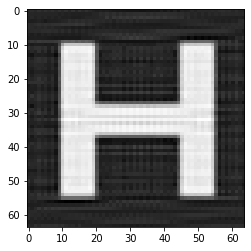

In [7]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### Convergence

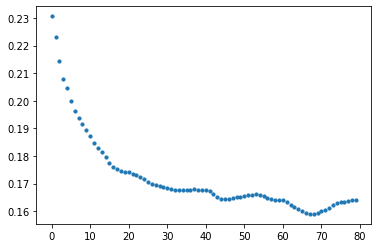

In [8]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

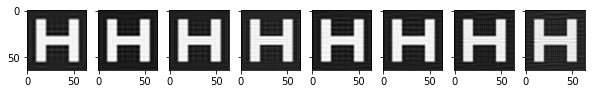

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

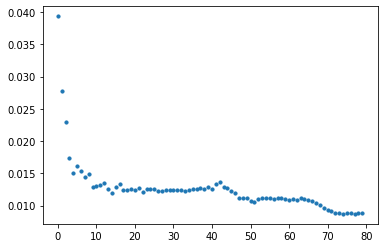

In [10]:
plt.scatter(range(len(solver.lambda_history)), solver.lambda_history, s=10)

### run MMGKS with DP

In [11]:
solver = MMGKSClass(pnorm=2, qnorm=1, projection_dim=3, regparam='dp', dp_stop=False, eta=1.01, delta=la.norm(e), tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running MMGKS...:  22%|██▎       | 18/80 [00:00<00:01, 56.44it/s]c:\Users\conno\repos\multiparameter_package\trips\parameter_selection\discrepancy_principle.py:50: RuntimeWarning: divide by zero encountered in true_divide
  beta_new = beta - f/f_prime
c:\Users\conno\repos\multiparameter_package\trips\parameter_selection\discrepancy_principle.py:53: RuntimeWarning: invalid value encountered in subtract
  if abs(beta_new - beta) < 10**(-7)* beta:
running MMGKS...: 100%|██████████| 80/80 [00:05<00:00, 13.60it/s]


array([[-0.01921728],
       [ 0.03219329],
       [ 0.04461434],
       ...,
       [ 0.02660301],
       [-0.00220253],
       [-0.03054102]])

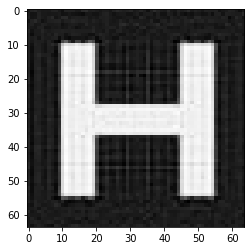

In [12]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### Convergence

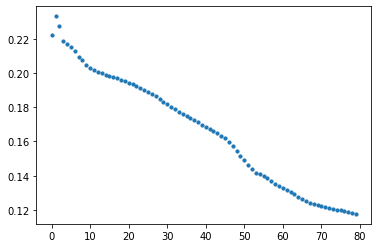

In [13]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

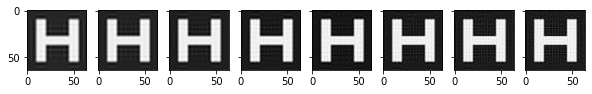

In [14]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

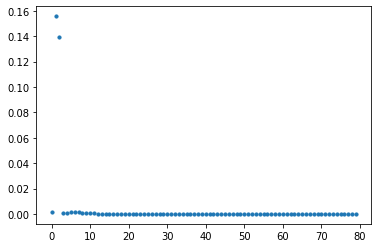

In [15]:
plt.scatter(range(len(solver.lambda_history)), solver.lambda_history, s=10)

### run MMGKS with a sequence of parameter values

In [16]:
regvals = [0.001*(0.5**(x)) for x in range(0,80)]

In [17]:
solver = MMGKSClass(pnorm=2, qnorm=1, projection_dim=3, regparam=regvals, dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running MMGKS...: 100%|██████████| 80/80 [00:03<00:00, 20.33it/s] 


array([[-0.00146313],
       [ 0.01902238],
       [ 0.02076036],
       ...,
       [ 0.03273711],
       [ 0.00257445],
       [-0.00122368]])

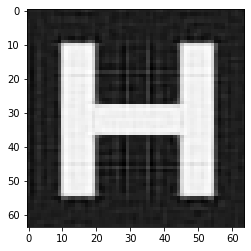

In [18]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

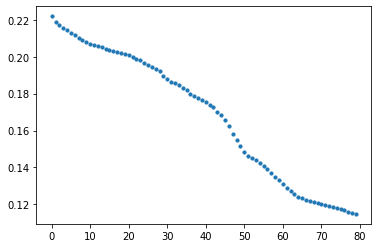

In [19]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

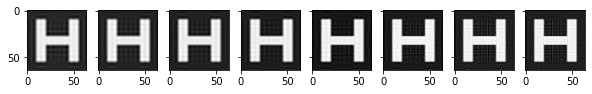

In [20]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

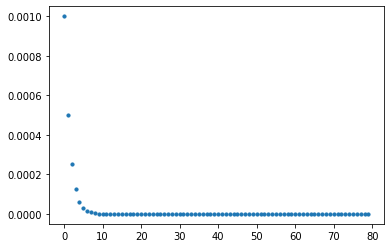

In [21]:
plt.scatter(range(len(solver.lambda_history)), solver.lambda_history, s=10)

### run GKS with a sequence of parameter values, initialized by gcv

In [22]:
# first, run several iterations with crossvalidation.
solver = MMGKSClass(pnorm=2, qnorm=1, projection_dim=3, regparam='gcv', dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=10, x_true=x_true)

# then use the estimated to initialize a sequence of values.
regvals = [solver.lambda_history[-1]*(0.5**(x)) for x in range(0,80)]
solver.change_regparam(regvals)
solver.run(blur_operator, b, D, iter=80, x_true=x_true, warm_start=True)

running MMGKS...: 100%|██████████| 80/80 [00:04<00:00, 16.72it/s]


array([[ 0.01240672],
       [ 0.02399027],
       [ 0.00826361],
       ...,
       [ 0.0389388 ],
       [-0.01014931],
       [ 0.0047693 ]])

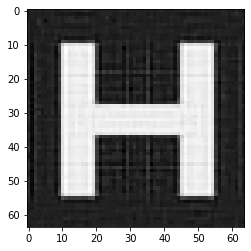

In [23]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

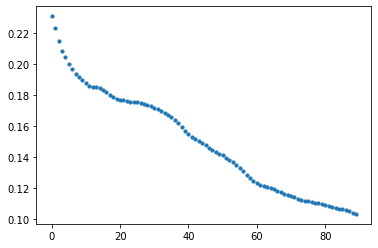

In [24]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

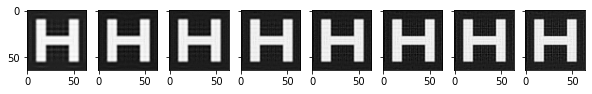

In [25]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[10+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

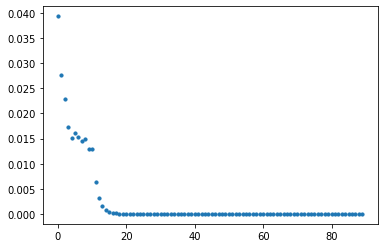

In [26]:
plt.scatter(range(len(solver.lambda_history)), solver.lambda_history, s=10)